In [12]:
# Cormac Greaney / 22352228 & Jan Lawinski / 22340343
# The code does execture to the end without error 
# Placeholer for links to third party implementations

In [ ]:
# ============================================================
# Installation Cell
# ------------------------------------------------------------
# These pip commands install everything required for this
# notebook to run on a fresh machine
# ============================================================

# --- Core RL + Atari dependencies ---
# !pip install "gymnasium[atari,accept-rom-license]"
# !pip install ale-py

# --- Numerical + plotting utilities ---
# !pip install numpy
# !pip install matplotlib

# --- Image processing for preprocessing frames ---
# !pip install opencv-python

# --- Deep learning framework (we're using PyTorch) ---
# !pip install torch

# --- (Optional) If you're running on Windows and have issues ---
# !pip install --upgrade pip


In [7]:
import gymnasium as gym            # main RL library
import numpy as np                 # handy for arrays
import matplotlib.pyplot as plt    # for visuals
import ale_py                      # Atari emulator backend

# Plug the Atari environments into Gymnasium.
# Without this, Pong won't appear in the registry.
gym.register_envs(ale_py)


In [8]:
# Make a Pong environment that returns RGB frames so we can display them.
env = gym.make("PongNoFrameskip-v4", render_mode="rgb_array")

# Reset the environment to start a new game.
obs, info = env.reset()

# Just print what kind of data we got back.
print("Obs type/shape:", type(obs), getattr(obs, "shape", None))


Obs type/shape: <class 'numpy.ndarray'> (210, 160, 3)


In [9]:
# We'll collect a few frames by taking random actions.
terminated = False
truncated = False
frames = []

for t in range(200):
    # Choose a random action from Pong's action space.
    action = env.action_space.sample()
    
    # Step the environment forward.
    obs, reward, terminated, truncated, info = env.step(action)
    
    # Save the frame so we can preview it later.
    frames.append(obs)
    
    # Stop early if the episode ends.
    if terminated or truncated:
        break

print("Collected", len(frames), "frames")


Collected 200 frames


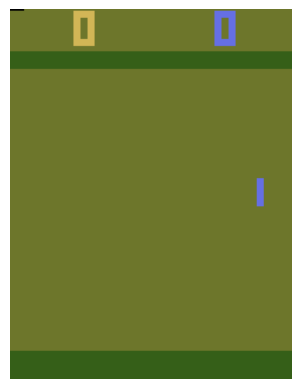

In [10]:
# Display the very first frame we grabbed.
plt.imshow(frames[0])
plt.axis("off")
plt.show()


Processed shape: (84, 84)


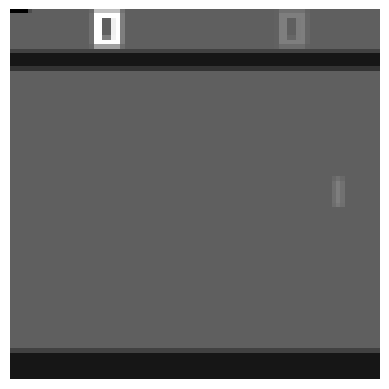

In [11]:
import cv2  # used for converting to grayscale and resizing

def preprocess_frame(frame):
    """
    Take a raw (210x160x3) RGB frame from Pong
    and convert it into a clean 84x84 grayscale image
    that the DQN can actually learn from.
    """

    # Turn the RGB frame into a grayscale image.
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

    # Shrink from (210x160) down to (84x84), which is the standard DQN input size.
    resized = cv2.resize(gray, (84, 84), interpolation=cv2.INTER_AREA)

    # Convert pixel values from 0–255 integers into 0–1 floats.
    normalized = resized.astype(np.float32) / 255.0

    return normalized


# Test the preprocessing on the first frame we collected earlier.
processed = preprocess_frame(frames[0])

print("Processed shape:", processed.shape)

# Show the processed grayscale image so we know it looks right.
plt.imshow(processed, cmap="gray")
plt.axis("off")
plt.show()


In [13]:
from collections import deque

class FrameStack:
    """
    Keep a rolling window of the last N processed frames.
    This lets the agent see short-term motion instead of a single static image.
    """

    def __init__(self, num_frames=4):
        self.num_frames = num_frames
        self.frames = deque(maxlen=num_frames)

    def reset(self, initial_frame):
        """
        Called at the start of an episode.
        We take the very first raw frame, preprocess it,
        and then duplicate it N times so the stacked state is well-defined.
        """
        processed = preprocess_frame(initial_frame)

        self.frames.clear()
        for _ in range(self.num_frames):
            self.frames.append(processed)

        # Shape will be (num_frames, 84, 84)
        return np.stack(self.frames, axis=0)

    def step(self, new_frame):
        """
        Called every time we get a new raw frame from the environment.
        We preprocess it and push it into the stack, automatically
        dropping the oldest frame.
        """
        processed = preprocess_frame(new_frame)
        self.frames.append(processed)

        return np.stack(self.frames, axis=0)


In [14]:
# Make a fresh environment reset so we have a clean starting frame.
obs, info = env.reset()

# Create a frame stacker that holds the last 4 frames.
frame_stack = FrameStack(num_frames=4)

# Build the initial stacked state from the very first frame.
state = frame_stack.reset(obs)
print("Initial stacked state shape:", state.shape)  # expected: (4, 84, 84)

# Take a few random steps and update the frame stack.
for t in range(3):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    state = frame_stack.step(obs)
    print(f"After step {t+1}, state shape:", state.shape)


Initial stacked state shape: (4, 84, 84)
After step 1, state shape: (4, 84, 84)
After step 2, state shape: (4, 84, 84)
After step 3, state shape: (4, 84, 84)


In [15]:
import random
from collections import deque

class ReplayBuffer:
    """
    Simple experience replay buffer.
    Stores (state, action, reward, next_state, done) tuples.

    - state / next_state: stacked frames, shape (4, 84, 84)
    - action: integer (which action was taken)
    - reward: float
    - done: bool (True if the episode ended)
    """

    def __init__(self, capacity):
        # 'capacity' is the max number of transitions we keep.
        # Once we hit this limit, the oldest experiences get dropped.
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        """
        Save a single experience into the buffer.
        We store raw numpy arrays / values here.
        """
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        """
        Randomly sample a batch of experiences.
        This is what the DQN will train on.
        """
        batch = random.sample(self.buffer, batch_size)

        # Unzip the batch into separate arrays.
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert to numpy arrays for easier handling later.
        states      = np.stack(states, axis=0)        # (batch, 4, 84, 84)
        next_states = np.stack(next_states, axis=0)   # (batch, 4, 84, 84)
        actions     = np.array(actions, dtype=np.int64)
        rewards     = np.array(rewards, dtype=np.float32)
        dones       = np.array(dones, dtype=np.float32)  # will be 0.0 or 1.0

        return states, actions, rewards, next_states, dones

    def __len__(self):
        """
        Let len(buffer) tell us how many experiences we have stored.
        This is handy for checking if we have enough to start training.
        """
        return len(self.buffer)


In [ ]:
# Create a replay buffer that can store up to 10,000 transitions.
replay_buffer = ReplayBuffer(capacity=100_000)

# Use the existing frame stack to generate a handful of fake experiences.
obs, info = env.reset()
frame_stack = FrameStack(num_frames=4)
state = frame_stack.reset(obs)

for t in range(20):
    # Take a random action.
    action = env.action_space.sample()
    next_obs, reward, terminated, truncated, info = env.step(action)
    next_state = frame_stack.step(next_obs)

    done = terminated or truncated

    # Store the transition in the buffer.
    replay_buffer.push(state, action, reward, next_state, done)

    state = next_state

    if done:
        break

print("Buffer size after rollout:", len(replay_buffer))

# Try sampling a mini-batch.
batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones = replay_buffer.sample(batch_size=8)

print("Batch states shape:", batch_states.shape)        # (8, 4, 84, 84)
print("Batch next_states shape:", batch_next_states.shape)
print("Batch actions shape:", batch_actions.shape)
print("Batch rewards shape:", batch_rewards.shape)
print("Batch dones shape:", batch_dones.shape)


Buffer size after rollout: 20
Batch states shape: (8, 4, 84, 84)
Batch next_states shape: (8, 4, 84, 84)
Batch actions shape: (8,)
Batch rewards shape: (8,)
Batch dones shape: (8,)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    """
    Convolutional Deep Q-Network for Pong.

    Input:  (batch, 4, 84, 84) stacked preprocessed frames
    Output: (batch, num_actions) predicted Q-values
    """

    def __init__(self, num_actions):
        super().__init__()

        # First block of convolutions extracts basic motion/edge features.
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)

        # Second block extracts mid-level spatial features.
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)

        # Third block captures more complex movement patterns.
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        # The final size after these conv layers is 64 feature maps of size 7x7.
        self.fc1 = nn.Linear(64 * 7 * 7, 512)

        # Final layer outputs one Q-value per action.
        self.fc2 = nn.Linear(512, num_actions)

    def forward(self, x):
        # Convolution layers with ReLU activations.
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # Flatten before fully-connected layers.
        x = x.view(x.size(0), -1)

        # Hidden layer + ReLU.
        x = F.relu(self.fc1(x))

        # Output layer: raw Q-values.
        return self.fc2(x)


# ==== Test forward pass ====

# Ask the environment how many actions exist in Pong.
num_actions = env.action_space.n
print("Number of actions:", num_actions)

# Create the network.
policy_net = DQN(num_actions=num_actions)

# Make a dummy batch of 2 random states to test the shape.
fake_states = np.random.rand(2, 4, 84, 84).astype(np.float32)
fake_states_tensor = torch.from_numpy(fake_states)

# Run the model without tracking gradients.
with torch.no_grad():
    q_values = policy_net(fake_states_tensor)

print("Q-values shape:", q_values.shape)  # expected: (2, num_actions)


Number of actions: 6
Q-values shape: torch.Size([2, 6])


In [18]:
# Device setup: use GPU if available, otherwise CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Hyperparameters for DQN.
gamma = 0.99          # discount factor for future rewards
batch_size = 32       # how many experiences to sample per training step
learning_rate = 1e-4  # how fast we update the network weights

# Create both the policy network and the target network.
# - policy_net: the one we train on every step.
# - target_net: a slowly updated copy used to compute stable target values.
policy_net = DQN(num_actions=env.action_space.n).to(device)
target_net = DQN(num_actions=env.action_space.n).to(device)

# Copy the weights from policy_net -> target_net at the start.
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()  # target_net is not trained directly, only updated by copying.

# Optimizer: Adam is a solid default choice for DQN.
optimizer = torch.optim.Adam(policy_net.parameters(), lr=learning_rate)


def optimize_model(replay_buffer):
    """
    Perform one gradient descent step on the DQN using a batch of
    experiences sampled from the replay buffer.

    This is where the core Q-learning update happens.
    """

    # We need at least 'batch_size' experiences before we can train.
    if len(replay_buffer) < batch_size:
        return None  # not enough data yet, skip the update

    # ---- 1. Sample a batch of experiences from the replay buffer ----
    states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

    # Convert numpy arrays to PyTorch tensors and move them to the right device.
    states      = torch.from_numpy(states).to(device)          # (batch, 4, 84, 84)
    next_states = torch.from_numpy(next_states).to(device)     # (batch, 4, 84, 84)
    actions     = torch.from_numpy(actions).to(device)         # (batch,)
    rewards     = torch.from_numpy(rewards).to(device)         # (batch,)
    dones       = torch.from_numpy(dones).to(device)           # (batch,)

    # ---- 2. Compute Q(s, a) for the actions actually taken ----
    # policy_net(states) gives Q-values for ALL actions in each state: shape (batch, num_actions).
    q_values = policy_net(states)  # Q(s, ·)

    # We only want the Q-values for the specific actions we took.
    # actions has shape (batch,), so we use gather to pick the right column per row.
    # Unsqueeze(1) makes actions shape (batch, 1), so gather returns (batch, 1), then we squeeze back to (batch,).
    state_action_values = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)  # Q(s, a_taken)

    # ---- 3. Compute target values: r + gamma * max_a' Q_target(s', a') ----
    with torch.no_grad():
        # Get Q-values for next_states from the target network.
        next_q_values = target_net(next_states)  # shape (batch, num_actions)

        # For each next_state, pick the maximum Q-value across actions.
        max_next_q_values, _ = next_q_values.max(dim=1)  # shape (batch,)

        # If done == 1, we don't bootstrap from the next state (no future reward).
        # So we multiply by (1 - dones) to zero out the next_q term when the episode ended.
        target_values = rewards + gamma * max_next_q_values * (1.0 - dones)

    # ---- 4. Compute the loss between current Q(s, a) and target values ----
    # We use mean squared error: L = mean( (Q(s,a) - target)^2 ).
    loss = F.mse_loss(state_action_values, target_values)

    # ---- 5. Backpropagation: update the policy network weights ----
    optimizer.zero_grad()  # clear old gradients
    loss.backward()        # compute new gradients
    optimizer.step()       # update the weights

    # Return the loss value (as a Python float) for logging if needed.
    return loss.item()


# === Quick dry run to see if it works without blowing up ===

# Only run this if we have enough experiences in the buffer.
if len(replay_buffer) >= batch_size:
    loss_value = optimize_model(replay_buffer)
    print("One optimization step done, loss:", loss_value)
else:
    print(f"Not enough samples in replay buffer yet: {len(replay_buffer)} / {batch_size}")


Using device: cuda
Not enough samples in replay buffer yet: 20 / 32


In [19]:
# Epsilon-greedy parameters:
epsilon_start = 1.0    # at the very beginning: act completely random
epsilon_end   = 0.1    # minimum amount of randomness
epsilon_decay = 1_000_000  # how many steps it takes to go from 1.0 -> 0.1

# This will track how many environment steps we've taken so far.
# We'll use it to slowly decay epsilon over time.
steps_done = 0

def get_epsilon(step):
    """
    Linearly decay epsilon from epsilon_start down to epsilon_end
    over 'epsilon_decay' steps.

    After that many steps, epsilon stays at epsilon_end.
    """
    if step >= epsilon_decay:
        return epsilon_end

    # Linear interpolation between start and end.
    fraction = step / epsilon_decay
    return epsilon_start + fraction * (epsilon_end - epsilon_start)


def select_action(state):
    """
    Choose an action using an epsilon-greedy policy.

    - With probability epsilon: pick a random action.
    - Otherwise: pick the action with the highest Q-value from the policy network.

    'state' is expected to be a numpy array with shape (4, 84, 84).
    """
    global steps_done

    # Compute current epsilon based on how many steps we've taken.
    epsilon = get_epsilon(steps_done)
    steps_done += 1

    # Decide: explore or exploit?
    if np.random.rand() < epsilon:
        # Explore: random action.
        action = env.action_space.sample()
        return action, epsilon

    # Exploit: choose best action according to the current Q-network.
    # We need to turn state into a torch tensor with shape (1, 4, 84, 84).
    state_tensor = torch.from_numpy(state).unsqueeze(0).to(device)  # add batch dimension

    with torch.no_grad():
        q_values = policy_net(state_tensor)  # shape: (1, num_actions)
        # Take the index of the largest Q-value.
        action = int(torch.argmax(q_values, dim=1).item())

    return action, epsilon


# === Quick sanity check ===

# Use current frame stack to create a state.
obs, info = env.reset()
frame_stack = FrameStack(num_frames=4)
state = frame_stack.reset(obs)

# Ask the policy for an action a few times.
for i in range(5):
    action, eps = select_action(state)
    print(f"Step {i}, epsilon={eps:.3f}, chosen action={action}")


Step 0, epsilon=1.000, chosen action=0
Step 1, epsilon=1.000, chosen action=1
Step 2, epsilon=1.000, chosen action=2
Step 3, epsilon=1.000, chosen action=3
Step 4, epsilon=1.000, chosen action=3


In [20]:
# Training settings.
num_episodes = 10            # start small to make sure everything works; can increase later
target_update_interval = 5   # how often (in episodes) to copy weights to target_net

episode_rewards = []         # track total reward per episode
global steps_done
steps_done = 0               # reset the global step counter for epsilon

for episode in range(1, num_episodes + 1):
    # Reset the environment and frame stack at the start of each episode.
    obs, info = env.reset()
    frame_stack = FrameStack(num_frames=4)
    state = frame_stack.reset(obs)

    done = False
    episode_reward = 0.0

    while not done:
        # 1. Choose an action with epsilon-greedy.
        action, epsilon = select_action(state)

        # 2. Take the action in the environment.
        next_obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        # 3. Update the frame stack and build the next state.
        next_state = frame_stack.step(next_obs)

        # 4. Store this transition in the replay buffer.
        replay_buffer.push(state, action, reward, next_state, done)

        # 5. Move on to the next state.
        state = next_state

        # 6. Accumulate reward for logging.
        episode_reward += reward

        # 7. Run one optimization step on the policy network.
        loss_value = optimize_model(replay_buffer)

    # Track the total reward for this episode.
    episode_rewards.append(episode_reward)

    # Periodically update the target network to match the policy net.
    if episode % target_update_interval == 0:
        target_net.load_state_dict(policy_net.state_dict())
        print(f"[Episode {episode}] Target network updated.")

    # Print a short summary for this episode.
    print(
        f"Episode {episode}/{num_episodes} | "
        f"Total reward: {episode_reward:.1f} | "
        f"Epsilon: {get_epsilon(steps_done):.3f} | "
        f"Buffer size: {len(replay_buffer)}"
    )

print("Training loop finished.")


Episode 1/10 | Total reward: -19.0 | Epsilon: 0.997 | Buffer size: 3766
Episode 2/10 | Total reward: -21.0 | Epsilon: 0.994 | Buffer size: 6822
Episode 3/10 | Total reward: -19.0 | Epsilon: 0.990 | Buffer size: 10000
Episode 4/10 | Total reward: -21.0 | Epsilon: 0.987 | Buffer size: 10000
[Episode 5] Target network updated.
Episode 5/10 | Total reward: -21.0 | Epsilon: 0.984 | Buffer size: 10000
Episode 6/10 | Total reward: -20.0 | Epsilon: 0.981 | Buffer size: 10000
Episode 7/10 | Total reward: -20.0 | Epsilon: 0.978 | Buffer size: 10000
Episode 8/10 | Total reward: -21.0 | Epsilon: 0.975 | Buffer size: 10000
Episode 9/10 | Total reward: -21.0 | Epsilon: 0.972 | Buffer size: 10000
[Episode 10] Target network updated.
Episode 10/10 | Total reward: -20.0 | Epsilon: 0.969 | Buffer size: 10000
Training loop finished.


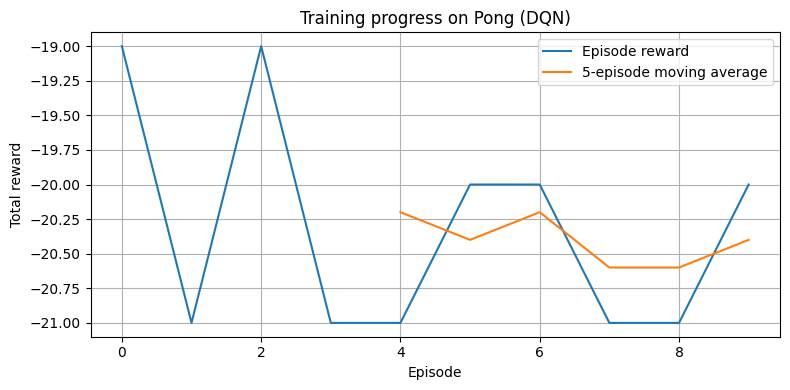

Episode rewards: [-19.0, -21.0, -19.0, -21.0, -21.0, -20.0, -20.0, -21.0, -21.0, -20.0]


In [21]:
# Simple reward plotting for quick feedback on training progress.

plt.figure(figsize=(8, 4))

# Plot raw episode rewards.
plt.plot(episode_rewards, label="Episode reward")

# Add a simple moving average to smooth things a bit (window = 5).
if len(episode_rewards) >= 5:
    window = 5
    moving_avg = np.convolve(
        episode_rewards, 
        np.ones(window) / window, 
        mode="valid"
    )
    plt.plot(
        range(window - 1, len(episode_rewards)), 
        moving_avg, 
        label=f"{window}-episode moving average"
    )

plt.xlabel("Episode")
plt.ylabel("Total reward")
plt.title("Training progress on Pong (DQN)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Episode rewards:", episode_rewards)


In [ ]:
# ============================================================
# Full Training Loop (Configurable)
# ------------------------------------------------------------
# This cell lets we train the DQN for a longer run, e.g., 500+
# episodes, with proper logging and target-network updates.
# For the assignment, we will likely run multiple sessions and
# compare plots.
# ============================================================

# Reset counters and storage for a fresh training run.
steps_done = 0
episode_rewards = []

# Training configuration (adjust as needed)
num_episodes = 500          # increase for real training (500–2000 recommended)
target_update_interval = 20
max_steps_per_episode = 10000   # safety cutoff to avoid infinite loops

print("Starting training...\n")

for episode in range(1, num_episodes + 1):
    obs, info = env.reset()
    frame_stack = FrameStack(num_frames=4)
    state = frame_stack.reset(obs)

    episode_reward = 0.0
    done = False
    step = 0

    while not done and step < max_steps_per_episode:
        step += 1

        # Pick an action based on epsilon-greedy policy.
        action, epsilon = select_action(state)

        # Interact with the environment.
        next_obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        # Update stacked frames → next state
        next_state = frame_stack.step(next_obs)

        # Save transition
        replay_buffer.push(state, action, reward, next_state, done)

        # Move forward
        state = next_state
        episode_reward += reward

        # Training step
        optimize_model(replay_buffer)

    episode_rewards.append(episode_reward)

    # Sync target network weights at intervals
    if episode % target_update_interval == 0:
        target_net.load_state_dict(policy_net.state_dict())

    # Episode summary
    print(
        f"Episode {episode:4d}/{num_episodes} | "
        f"Reward: {episode_reward:5.1f} | "
        f"Epsilon: {get_epsilon(steps_done):.3f} | "
        f"Buffer: {len(replay_buffer)}"
    )

print("\nTraining finished.")


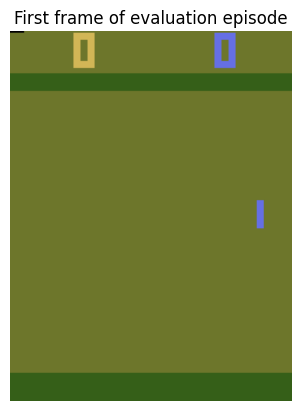

Evaluation episode finished. Total reward: -21.0
Number of frames collected: 3056


In [22]:
def run_evaluation_episode(render_first_frame=True):
    """
    Run a single evaluation episode using a purely greedy policy
    (no random exploration) and return the total reward.

    Optionally shows the first frame so we know it's working.
    """

    # Make sure the policy network is in eval mode (disables dropout etc., if present).
    policy_net.eval()

    # Reset the environment and frame stack.
    obs, info = env.reset()
    frame_stack = FrameStack(num_frames=4)
    state = frame_stack.reset(obs)

    done = False
    total_reward = 0.0
    frames_eval = []  # store frames here if we want to turn them into a video later

    while not done:
        # Convert state to a batch of size 1.
        state_tensor = torch.from_numpy(state).unsqueeze(0).to(device)

        # No epsilon here: purely greedy action selection.
        with torch.no_grad():
            q_values = policy_net(state_tensor)
            action = int(torch.argmax(q_values, dim=1).item())

        # Step the env with the chosen action.
        next_obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        # Update frame stack and accumulate reward.
        state = frame_stack.step(next_obs)
        total_reward += reward

        # Save the raw frame for possible video export later.
        frames_eval.append(next_obs)

    # Optionally show the very first frame of the evaluation run.
    if render_first_frame and len(frames_eval) > 0:
        plt.imshow(frames_eval[0])
        plt.axis("off")
        plt.title("First frame of evaluation episode")
        plt.show()

    print(f"Evaluation episode finished. Total reward: {total_reward:.1f}")
    print(f"Number of frames collected: {len(frames_eval)}")

    return total_reward, frames_eval


# ---- Quick smoke test: run one evaluation episode ----
eval_reward, eval_frames = run_evaluation_episode(render_first_frame=True)


In [23]:
import cv2

def save_video(frames, filename="pong_evaluation.mp4", fps=30):
    """
    Save a list of RGB frames (H, W, 3) as a video file using OpenCV.

    - frames: list of numpy arrays from the environment (RGB).
    - filename: output video file name.
    - fps: frames per second for the video.
    """

    if len(frames) == 0:
        print("No frames to save, skipping video.")
        return

    # Get frame height and width from the first frame.
    height, width, _ = frames[0].shape

    # FourCC code for mp4 output; should work on most setups.
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    video_writer = cv2.VideoWriter(filename, fourcc, fps, (width, height))

    for frame in frames:
        # OpenCV expects BGR, but Gym gives RGB.
        bgr_frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        video_writer.write(bgr_frame)

    video_writer.release()
    print(f"Video saved to: {filename}")


# Use the frames from the last evaluation run.
save_video(eval_frames, filename="pong_evaluation.mp4", fps=30)


Video saved to: pong_evaluation.mp4
